## Preprocessing

In [1]:
# !pip install pandas openpyxl
# ! pip install xlrd

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import datetime
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt

In [3]:
# read xls file 
xls = pd.ExcelFile(r"数据分析数据源_脱敏_20230324.xls")
sheetxls = xls.parse(0)
sheetxls_price = xls.parse(1)

# extract Siemens data
siemens_dat = sheetxls.loc[sheetxls['brand'] == "西门子"]

# sort by user_id & installation_date
siemens_dat = siemens_dat.sort_values(by = ['user_id', 'installation_date'])
siemens_dat = siemens_dat.drop('brand', axis = 1)

print('西门子客户购买品类有: ', siemens_dat['prod_group'].unique())
print('西门子客户地区有: ', siemens_dat['province'].unique())

西门子客户购买品类有:  ['洗碗机' '洗衣机' '灶具' '冰箱' '蒸/烤箱' '烘干机' '吸油烟机']
西门子客户地区有:  ['江苏' '广东' '河北' '广西' '河南' '江西' '新疆' '山西']


In [4]:
# define a dictionary for following steps
user_id = list(siemens_dat['user_id'].unique())
siemens_user_dat = {}
for user in user_id: 
    siemens_user_dat[user] = siemens_dat.loc[siemens_dat['user_id'] == user]
del user

# calculate time difference from first purchase
for user in user_id: 
    time_stamp_list = list(siemens_user_dat[user]['installation_date'])
    time_lag = []
    for i in range(len(time_stamp_list)):
        time_lag.append(time_stamp_list[i] - time_stamp_list[0])
    siemens_user_dat[user]['time_lag'] = time_lag
del time_stamp_list, time_lag

# extract 1 yr return purchase data for each customer
siemens_user_dat_1yr = {}
time_judge = datetime.timedelta(days = 360)
for user in user_id: 
    df = siemens_user_dat[user]
    siemens_user_dat_1yr[user] = df.loc[df['time_lag'] < time_judge] 
del df

## 1 西门子客户首购品类关联性分析

### 1.1 客户首购产品分布

In [5]:
col_names = list(siemens_user_dat_1yr[0].columns)
siemens_1st = pd.DataFrame(columns = col_names)
for i in range(len(user_id)): 
    user = user_id[i]
    siemens_1st.loc[i] = list(siemens_user_dat_1yr[user].iloc[0])
del user, col_names

**以下为西门子顾客首购产品分布:**

In [6]:
siemens_1st['prod_group'].value_counts()

洗衣机     123
冰箱       76
洗碗机      31
灶具       26
吸油烟机     18
蒸/烤箱     11
烘干机       6
Name: prod_group, dtype: int64

**该数据中, 西门子共有291位顾客. 其中, 接近一半西门子顾客首购的产品为洗衣机(42.2%), 冰箱(26.1%)其次. 此处需声明, 关于吸油烟机, 蒸/烤箱, 烘干机后续的关联购买分析因样本数量过少可能缺乏代表性.** 

### 1.2 客户首购产品关联购买率

In [7]:
indexes = siemens_dat['prod_group'].unique()
col_names = np.concatenate((['首购频次'], ['关联购买频次'], indexes))
prod_related_purchase = pd.DataFrame(0, index=indexes, columns=col_names)
del indexes, col_names

# way to extract values 
# prod_related_purchase.loc[['冰箱']]['冰箱']
for user in siemens_user_dat_1yr.keys(): 
    df = siemens_user_dat_1yr[user]
    rows = df.shape[0]
    row_loc = df.iloc[0]['prod_group']
    if rows>1:
        prod_related_purchase.loc[[row_loc], '关联购买频次'] += 1
    for i in range(rows):
        if i == 0:
            prod_related_purchase.loc[[row_loc], '首购频次'] += 1
        else: 
            prod_related_purchase.loc[[row_loc], df.iloc[i]['prod_group']] += 1

**以下表格为西门子顾客各类产品首购客户频次, 首购后360天内关联购买客户频次, 以及由此计算出的关联购买率**

In [8]:
prod_related_purchase['关联购买率'] = round(prod_related_purchase['关联购买频次']/prod_related_purchase['首购频次'], 4)
prod_related_purchase

,首购频次,关联购买频次,洗碗机,洗衣机,灶具,冰箱,蒸/烤箱,烘干机,吸油烟机,关联购买率
洗碗机,31,13,4,16,2,6,0,0,2,0.4194
洗衣机,123,70,20,60,13,49,4,7,13,0.5691
灶具,26,17,2,16,0,7,1,3,4,0.6538
冰箱,76,48,14,48,6,25,4,3,5,0.6316
蒸/烤箱,11,8,5,15,1,3,0,1,1,0.7273
烘干机,6,3,0,1,0,1,0,1,1,0.5000
吸油烟机,18,13,4,8,2,8,1,2,1,0.7222


**该曲线图为关联购买率分布图**

<AxesSubplot:ylabel='Density'>

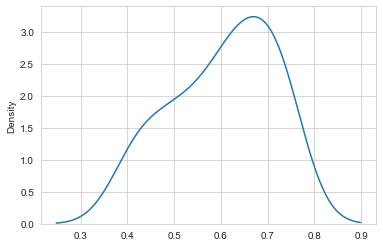

In [9]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(prod_related_purchase['关联购买率']), bw_method=0.5)

In [10]:
# 调出首购记录以及关联购买记录
def print_history(prod_group): 
    indicator = 0
    for user in siemens_user_dat_1yr.keys(): 
        df = siemens_user_dat_1yr[user]
        row_loc = df.iloc[0]['prod_group']
        if row_loc == prod_group:
            print(df)
            indicator += 1
    if indicator == 0:
        print('该产品不存在')

# exmaple to use the function
# print_history('烘干机')

### 1.3 客户首购产品关联购买分析结论

**从首购产品品类的角度, 72%的首购蒸/烤箱或者吸油烟机的顾客在后续360天内都进行了关联购买. 首购洗衣机, 炊具, 冰箱的顾客关联购买率也在60%左右. 然而首购洗碗机的顾客仅有40%左右在360天内进行了关联购买. 从七类产品的关联购买率的分布的角度来看, 近似服从均值0.65的正态分布. 也由此可推断:**
- 高关联购买率产品品类: 蒸/烤箱, 吸油烟机; 
- 一般关联购买率产品品类: 洗衣机, 灶具, 冰箱; 
- 低关联购买率产品品类: 洗碗机, 烘干机

**从关联购买产品品类的角度, 以下几组关联购买特征较为明显:**
- 顾客首购洗衣机, 灶具, 冰箱, 蒸/烤箱, 吸油烟机后, 如若发生关联购买, 关联购买产品中几乎一定有洗衣机;
- 顾客首购洗衣机, 冰箱, 蒸/烤箱后, 如若发生关联购买, 有超过50%的概率会购买冰箱;
- 然而, 无论顾客首购产品品类, 关联购买灶具, 蒸/烤箱, 烘干机, 吸油烟机的可能性都很小; 

## 2 西门子客户同品类复购情况以及复购间隔分析

### 2.1 西门子客户同品类复购情况

In [11]:
# build return purchase dictionary
products = siemens_dat['prod_group'].unique()
return_purchase_dict = {}
for prod in products: 
    temp_dict = {}
    for user in siemens_user_dat.keys():
        # extract purchase records for the product and customer
        user_df = siemens_user_dat[user]
        temp_df = user_df.loc[user_df['prod_group'] == prod]
        if not temp_df.empty:
            temp_df = temp_df[['user_id', 'vib', 'prod_group', 'province', 'installation_date']]
            temp_dict[user] = temp_df
    return_purchase_dict[prod] = temp_dict

del temp_dict, user_df, temp_df

for prod in return_purchase_dict.keys():
    prod_dict = return_purchase_dict[prod]
    for user in prod_dict.keys():
        user_df = prod_dict[user]
        time_stamp_list = list(user_df['installation_date'])
        time_lag = []
        for i in range(len(time_stamp_list)):
            if i == 0:
                time_lag.append(time_stamp_list[i] - time_stamp_list[0])
            else:
                time_lag.append(time_stamp_list[i] - time_stamp_list[i-1])
        user_df['time_lag'] = time_lag
        # filter < 360
        time_1 = datetime.timedelta(days = 360)
        time_2 = datetime.timedelta(days = 0)
        prod_dict[user] = user_df.loc[(user_df['time_lag'] > time_1) | (user_df['time_lag'] == time_2)] 
        prod_dict[user]['time_lag'] = prod_dict[user]['time_lag'].dt.days
    return_purchase_dict[prod] = prod_dict
del prod_dict, user_df, time_stamp_list, time_lag

In [12]:
col_names = np.array(['购买顾客', '复购顾客', '复购总量'])
indexes = siemens_dat['prod_group'].unique()
return_summary = pd.DataFrame(0, index=indexes, columns=col_names)
del col_names

for prod in return_purchase_dict.keys():
    for user in return_purchase_dict[prod].keys():
        user_df = return_purchase_dict[prod][user]
        return_summary.loc[prod]['购买顾客'] += 1
        rows = user_df.shape[0]
        if rows > 1:
            return_summary.loc[prod]['复购顾客'] += 1
        return_summary.loc[prod]['复购总量'] += (rows - 1)
del user_df, rows

return_summary['复购率'] = round(return_summary['复购顾客']/return_summary['购买顾客'], 3)
return_summary['复购率'] = (100.*return_summary['复购率']).round(1).astype(str) + '%'
return_summary['平均复购量'] = round(return_summary['复购总量']/return_summary['复购顾客'], 2)

In [13]:
return_summary

,购买顾客,复购顾客,复购总量,复购率,平均复购量
洗碗机,159,65,83,40.9%,1.28
洗衣机,251,162,245,64.5%,1.51
灶具,120,26,27,21.7%,1.04
冰箱,220,136,204,61.8%,1.50
蒸/烤箱,66,9,9,13.6%,1.00
烘干机,47,7,8,14.9%,1.14
吸油烟机,103,25,28,24.3%,1.12


**根据以上表格中的复购率和平均复购量, 可以对产品进行以下分类:**
- 复购表现优异产品品类(复购率40%+, 平均复购量1.5+): 洗碗机, 洗衣机, 冰箱;
- 复购表现一般产品品类(复购率20%+): 灶具, 吸油烟机;
- 复购表现较差产品品类(复购率<20%): 蒸/烤箱, 烘干机;

### 2.2 西门子客户同品类复购间隔分析

In [14]:
return_purchase_inr = {}
for prod in return_purchase_dict.keys():
    temp_list = []
    for user in return_purchase_dict[prod].keys():
        uesr_df = return_purchase_dict[prod][user]
        for lag in list(uesr_df['time_lag']):
            if not lag == 0:
                temp_list.append(lag)
    return_purchase_inr[prod] = temp_list

def Average(lst):
    return sum(lst) / len(lst)

In [15]:
col_names = np.array(['mean', 'median', 'std', '25%', '75%'])
return_inr_summary = pd.DataFrame(0, index=indexes, columns=col_names)
for prod in return_purchase_inr.keys():
    return_inr_summary.loc[prod,'mean'] = round(Average(return_purchase_inr[prod]), 2)
    return_inr_summary.loc[prod,'median'] = statistics.median(return_purchase_inr[prod])
    return_inr_summary.loc[prod,'std'] = np.std(return_purchase_inr[prod])
    return_inr_summary.loc[prod,'25%'] = pd.Series(return_purchase_inr[prod]).describe()[4]
    return_inr_summary.loc[prod,'75%'] = pd.Series(return_purchase_inr[prod]).describe()[6]
    
return_inr_summary

,mean,median,std,25%,75%
洗碗机,829.58,750.0,359.368962,518.50,1073.00
洗衣机,669.32,595.0,286.103289,447.00,785.00
灶具,948.19,856.0,367.840247,728.50,1119.00
冰箱,709.87,614.0,337.534549,451.50,831.50
蒸/烤箱,1068.67,1138.0,446.519130,689.00,1335.00
烘干机,1056.25,1033.5,383.930251,784.00,1379.25
吸油烟机,949.46,828.0,437.004779,597.25,1186.75


In [16]:
pd.Series(return_purchase_inr['冰箱']).describe()

count     204.000000
mean      709.872549
std       338.364894
min       364.000000
25%       451.500000
50%       614.000000
75%       831.500000
max      2101.000000
dtype: float64

**检查标准差大的两个品类的复购间隔分布**

[Text(0.5, 1.0, 'extractor hood')]

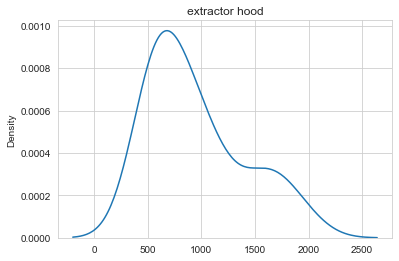

In [17]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(return_purchase_inr['吸油烟机']), bw_method=0.5).set(title = 'extractor hood')

[Text(0.5, 1.0, 'Steam Oven')]

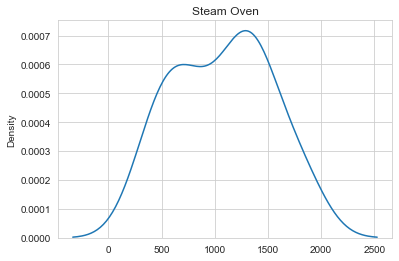

In [18]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(return_purchase_inr['蒸/烤箱']), bw_method=0.5).set(title = 'Steam Oven')

**根据以上图表, 可对产品复购间隔情况进行以下划分:**
- 复购间隔两年以上产品: 灶具, 烘干机, 蒸/烤箱; 
- 复购间隔两年至两年左右产品: 洗衣机, 冰箱; 
- 复购间隔波动较大产品: 洗碗机, 吸油烟机; 

### 2.3 客户复购情况及复购间隔分析结论

**根据以上分析可以得出, 从考虑复购的角度来说:** 
- 洗衣机和冰箱有较高的回购率且复购间隔相对稳定. 一定程度的说明客户对西门子这两类产品认可度较高; 
- 然而蒸/烤箱和烘干机, 复购率非常低的同时复购间隔较长. 短期来看收益相对较低;
- 剩余的灶具, 吸油烟机复购率表现较为一般的同时复购间隔不稳定, 短期内收益较难估计;
- 洗碗机在上一节分析中提到, 首购率低. 而于此同时复购率较高, 这说明对于目前客户来说属于反响良好低新颖产品, 其长期表现有待观察;

## 3 有待提升部分

### 3.1 地区因素

**未纳入地区因素原因:**

主要是由于西门子顾客总数一共仅有291人, 而产品有七类. 于此同时, 顾客源来自八个省份. 若将省份考虑其中, 每一个子群顾客人数平均将小于10人, 在统计分析上很难继续进行下去. 除此之外, 对于同一个客户, 其地区常常是变化的. 该情况导致定义客户居住地, 来将地域的个性化特征考虑在内较为困难. 然而从尝试来判断, 该影响很有可能为切实存在的. 

### 3.2 产品型号

主要原因与地区因素类似, 产品型号相较于地区因素更为繁杂, 当样本数量量级提升时务必将纳入分析. 